<a href="https://colab.research.google.com/github/alyssarose05/ecommerce-analysis/blob/main/Kids_Pools_For_Backyard_Review_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Kids Pools For Backyard" Review Analysis

[WIRHAO Foldable Non-Inflatable Kids' and Adults' Outdoor Swimming Pool Hard Plastic Shell Kid Pool for Backyard Dog Pools (113" x 66" x 20")](https://www.amazon.com/Foldable-Non-Inflatable-Outdoor-Swimming-Backyard/dp/B0D3X5V8L7?th=1)

## Install and import packages

In [ ]:
# Install gensim library
!pip install gensim

In [ ]:
# Data manipulation
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Textual analysis
from textblob import TextBlob
from wordcloud import WordCloud

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Zero-shot classification
from transformers import pipeline

# Gensim
from gensim import corpora, models
from gensim.models import Phrases

# Ignore warnings from setting word clouds
import warnings
warnings.filterwarnings("ignore")

# Download nltk packages
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model = "facebook/bart-large-mnli")

Device set to use cpu


## Public Review Sentiments

In [ ]:
# Load data
reviews = pd.read_csv("/content/drive/MyDrive/Build Fellowship/June 2025/Alyssa Ayala/B0D3X5V8L7 - Foldable Non-Inflatable Kids' and Adults' Outdoor  2025-07-18.csv")
reviews = reviews[['Body', 'Rating']].dropna()
reviews = reviews.rename(columns = {'Body': 'review_text', 'Rating': 'star_rating'})

# Sentimental analysis
reviews['sentiment_score'] = reviews['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews = reviews.sort_values(by = 'sentiment_score')

# Preview dataframe
reviews.head(10)

,review_text,star_rating,sentiment_score
43,Too bulky and heavy so returned it.,1,-0.200000
5,"Nice, but packaging was very bad! It had two h...",3,-0.200000
23,The pool is a bit difficult to setup initially...,5,-0.160000
44,"Will keep, but disappointed that there was a h...",2,-0.058333
20,"Firstly, I measured after setting this up, it ...",2,-0.015000
26,We typically buy a kiddy inflatable pool each ...,5,0.004762
49,Good sturdy heavy item larger than expected un...,5,0.050000
10,"This foldable wonder is perfect for kids, adul...",4,0.087083
15,"This weighs about 50 pounds, so understand tha...",4,0.100000
37,This was a really nifty idea for people who ha...,4,0.107197


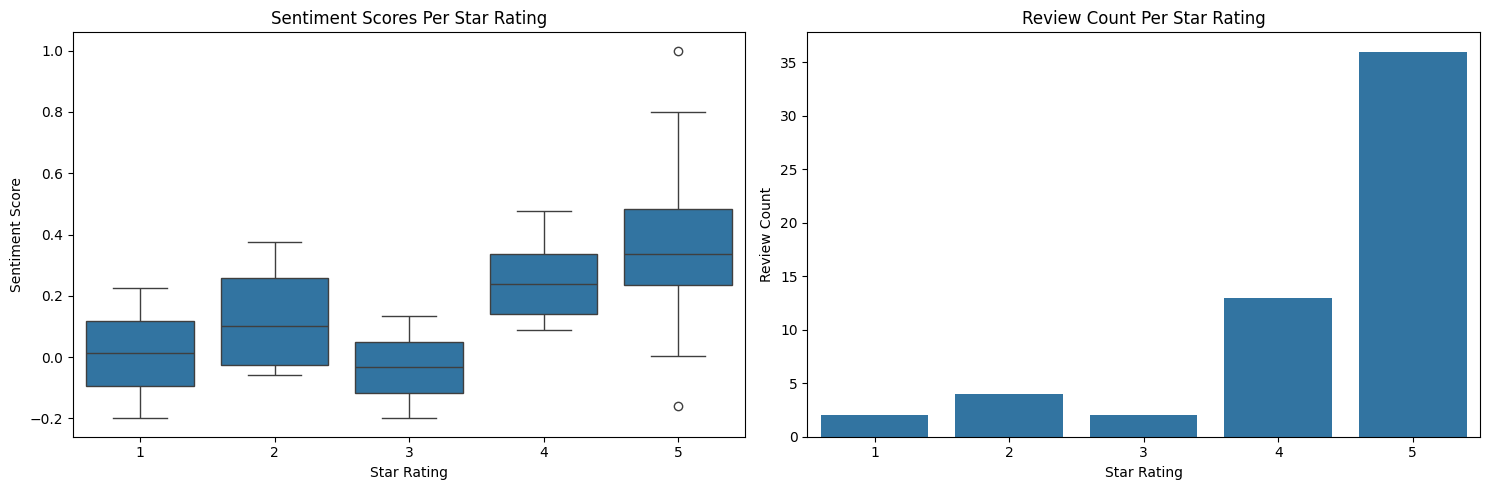

In [ ]:
# Set up two-viz layout
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Viz 1: Box plot of sentiment scores per star rating
sns.boxplot(data=reviews, x='star_rating', y='sentiment_score', ax=axs[0])
axs[0].set_title('Sentiment Scores Per Star Rating')
axs[0].set_xlabel('Star Rating')
axs[0].set_ylabel('Sentiment Score')

# Viz 2: Bar plot of review count per star rating
sns.countplot(data=reviews, x='star_rating', ax=axs[1])
axs[1].set_title('Review Count Per Star Rating')
axs[1].set_xlabel('Star Rating')
axs[1].set_ylabel('Review Count')

# Tight layout and show
plt.tight_layout()
plt.show()

A 3-star rating has both the lowest average sentiment score and review count, meaning its reviews may be more misleading compared to the other ones of different ratings.

For the rest of the ratings, both the sentiment scores and review counts rise as the star rating increases, which may make them more trustworthy than the 3-star ones.

## Topic Modeling (LDA)

In [ ]:
# Function to get tokens
stop_words = set(stopwords.words('english'))
def getTokens(text):
  tokens = word_tokenize(str.lower(text))
  tokens = [token for token in tokens if
            token.isalpha() and
            token not in stop_words and
            len(token) > 2]
  return tokens

# Create tokens column
reviews['tokens'] = reviews['review_text'].apply(getTokens)

# Add common phrases
bigram = Phrases(reviews['tokens'], min_count = 3, threshold = 5)
bigram_mod = Phrases(bigram[reviews['tokens']])
reviews['tokens'] = [bigram[doc] for doc in reviews['tokens']]

# Preview new dataframe
reviews.head(10)

,review_text,star_rating,sentiment_score,tokens
43,Too bulky and heavy so returned it.,1,-0.200000,"[bulky, heavy, returned]"
5,"Nice, but packaging was very bad! It had two h...",3,-0.200000,"[nice, packaging, bad, two, holes, opening, fi..."
23,The pool is a bit difficult to setup initially...,5,-0.160000,"[pool, bit, difficult, setup, initially, start..."
44,"Will keep, but disappointed that there was a h...",2,-0.058333,"[keep, disappointed, hole, top, pool, edges, d..."
20,"Firstly, I measured after setting this up, it ...",2,-0.015000,"[firstly, measured, setting, closer, including..."
26,We typically buy a kiddy inflatable pool each ...,5,0.004762,"[typically, buy, kiddy, inflatable, pool, year..."
49,Good sturdy heavy item larger than expected un...,5,0.050000,"[good, sturdy, heavy, item, larger, expected, ..."
10,"This foldable wonder is perfect for kids, adul...",4,0.087083,"[foldable, wonder, perfect, kids_adults, even,..."
15,"This weighs about 50 pounds, so understand tha...",4,0.100000,"[weighs, pounds, understand, heavy, great, adu..."
37,This was a really nifty idea for people who ha...,4,0.107197,"[really, nifty, idea, people, small, children,..."


### Word Clouds

In [ ]:
# Positive LDA reviews (>0 sentiment score)
positive_reviews = reviews[reviews['sentiment_score'] > 0]
positive_reviews['tokens'] = positive_reviews['review_text'].apply(getTokens)

positive_dictionary = corpora.Dictionary(positive_reviews['tokens'])
positive_corpus = [positive_dictionary.doc2bow(text) for text in positive_reviews['tokens']]

positive_lda_model = models.LdaModel(corpus = positive_corpus,
                                id2word = positive_dictionary,
                                passes = 20,
                                num_topics = 3
                                )

positive_topic_words = positive_lda_model.show_topics()

# Negative LDA reviews(<0 sentiment score)
negative_reviews = reviews[reviews['sentiment_score'] < 0]
negative_reviews['tokens'] = negative_reviews['review_text'].apply(getTokens)

negative_dictionary = corpora.Dictionary(negative_reviews['tokens'])
negative_corpus = [negative_dictionary.doc2bow(text) for text in negative_reviews['tokens']]

negative_lda_model = models.LdaModel(corpus = negative_corpus,
                                id2word = negative_dictionary,
                                passes = 20,
                                num_topics = 3
                                )

negative_topic_words = negative_lda_model.show_topics()

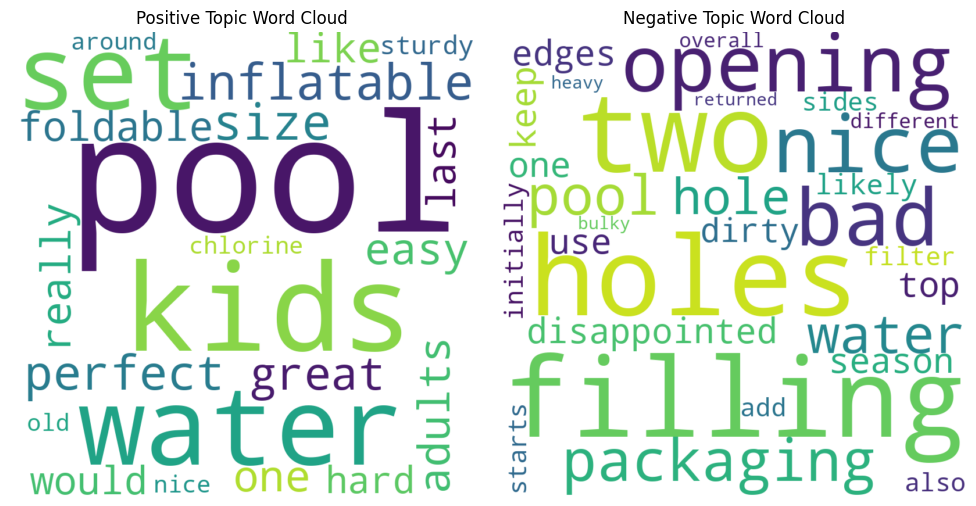

In [ ]:
# Set up 2-viz plot
plt.figure(figsize = (10, 5))

# Viz. 1: Positive Topic Word Cloud
positive_word_frequencies = {word: freq for topic in positive_topic_words for word, freq in positive_lda_model.show_topic(topic[0])}
positive_wordcloud = WordCloud(width = 800, height = 800, background_color = 'white').generate_from_frequencies(positive_word_frequencies)

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Positive Topic Word Cloud')

# Viz. 2: Negative Topic Word Cloud
negative_word_frequencies = {word: freq for topic in negative_topic_words for word, freq in negative_lda_model.show_topic(topic[0])}
negative_wordcloud = WordCloud(width = 800, height = 800, background_color = 'white').generate_from_frequencies(negative_word_frequencies)

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Negative Topic Word Cloud')

# Tight layout and show
plt.tight_layout()
plt.show()

According to these LDA models:
- Positive words like 'kids', 'easy', and 'perfect' signify customers who found the pool easy to set up for their kids.
- Negative words like 'hole', 'packaging', and 'disappointment' reveal some of the hidden pain points that may be within the 3-star ratings, like the potentially damaged packaging for kids.

## Zero-shot Classification (Facebook Model)

In [ ]:
# Set candidate labels based on the reviews and product
candidate_labels = [
    "great for kids",
    "easy to set up",
    "convenient storage",
    "too heavy",
    "poor packaging",
    "confusing instructions"
]

# Use the candidate labels to fit the Facebook model
reviews['zero_shot_label'] = reviews['review_text'].apply(
    lambda x: classifier(str(x), candidate_labels, multi_label = False)['labels'][0])

# Due to long fitting time: save results in a CSV file
reviews.to_csv('fitted_reviews.csv', index = False)

In [ ]:
# Preview final dataframe
reviews.head(10)

,review_text,star_rating,sentiment_score,tokens,zero_shot_label
0,Too bulky and heavy so returned it.,1,-0.200000,"['bulky', 'heavy', 'returned']",too heavy
1,"Nice, but packaging was very bad! It had two h...",3,-0.200000,"['nice', 'packaging', 'bad', 'two', 'holes', '...",poor packaging
2,The pool is a bit difficult to setup initially...,5,-0.160000,"['pool', 'bit', 'difficult', 'setup', 'initial...",confusing instructions
3,"Will keep, but disappointed that there was a h...",2,-0.058333,"['keep', 'disappointed', 'hole', 'top', 'pool'...",convenient storage
4,"Firstly, I measured after setting this up, it ...",2,-0.015000,"['firstly', 'measured', 'setting', 'closer', '...",too heavy
5,We typically buy a kiddy inflatable pool each ...,5,0.004762,"['typically', 'buy', 'kiddy', 'inflatable', 'p...",great for kids
6,Good sturdy heavy item larger than expected un...,5,0.050000,"['good', 'sturdy', 'heavy', 'item', 'larger', ...",too heavy
7,"This foldable wonder is perfect for kids, adul...",4,0.087083,"['foldable', 'wonder', 'perfect', 'kids_adults...",easy to setup
8,"This weighs about 50 pounds, so understand tha...",4,0.100000,"['weighs', 'pounds', 'understand', 'heavy', 'g...",too heavy
9,This was a really nifty idea for people who ha...,4,0.107197,"['really', 'nifty', 'idea', 'people', 'small',...",great for kids


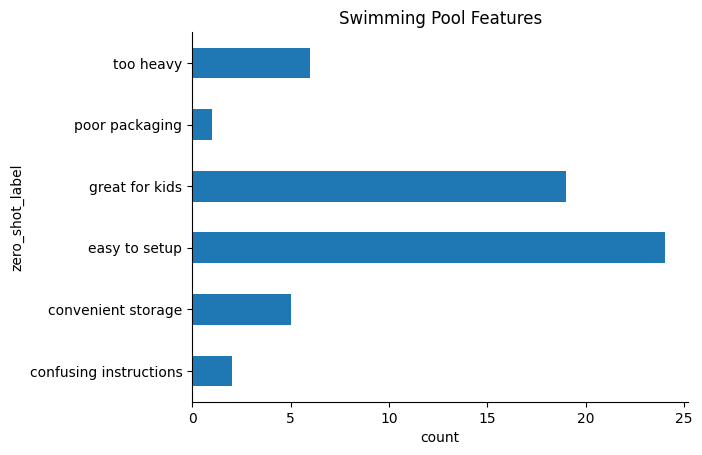

In [ ]:
# Count per candidate label, with percentages visible
reviews.groupby('zero_shot_label').size().plot(kind='barh')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title("Swimming Pool Features")
plt.xlabel('count')
plt.show()

In [ ]:
# Filter on positive sentiment scores
positive_reviews = reviews[reviews['sentiment_score'] > 0]

positive_reviews[['review_text', 'zero_shot_label']].head(3)

,review_text,zero_shot_label
5,We typically buy a kiddy inflatable pool each ...,great for kids
6,Good sturdy heavy item larger than expected un...,too heavy
7,"This foldable wonder is perfect for kids, adul...",easy to setup


In [ ]:
# Filter on negative sentiment scores
negative_reviews = reviews[reviews['sentiment_score'] < 0]

negative_reviews[['review_text', 'zero_shot_label']].head(3)


,review_text,zero_shot_label
0,Too bulky and heavy so returned it.,too heavy
1,"Nice, but packaging was very bad! It had two h...",poor packaging
2,The pool is a bit difficult to setup initially...,confusing instructions


The results of the Facebook model reflects what was demonstrated in the WordCloud created earlier. ~25 customers prefer a product that is easy to set up, while ~20 of them want the product to be child-friendly.

The most evident painpoint comes from the physical attributes of the pool, where ~7 customers commonly complain that the pool is too heavy. Large and bulky pools may not be preferred by parents in this case.

The pool's durability and other aspects are the smaller features that still appear in reviews, with 5 of them mainly caring about convenient storage, for example.